In [1]:
import json
import datetime as dt

In [2]:
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///../application/db/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Creates inspector that enables user to view columns within each table
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
station_columns = inspector.get_columns('station')
# measurement_columns
# station_columns

# Exploratory Climate Analysis

In [11]:
# Starting plot configurations
plt.rcParams.update({'font.size': 16})
plt.rcParams["text.color"] = "black"
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['xtick.color'] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

# Retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = str(int(last_date[0:4]) - 1) + last_date[4:8] + str(int(last_date[8:10]) + 1)

# Perform a query to retrieve the data and precipitation scores
prcp_last_12_months = session.query(Measurement.date, Measurement.prcp)\
                        .order_by(Measurement.date.desc())\
                            .filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago)\
                                .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_last_12_months).set_index("date")

# Sort the dataframe by date
prcp_df.fillna(value=0, inplace=True)
prcp_df.sort_values("date", ascending=True, inplace=True)
highs_per_day_df = prcp_df.groupby(["date"]).max()

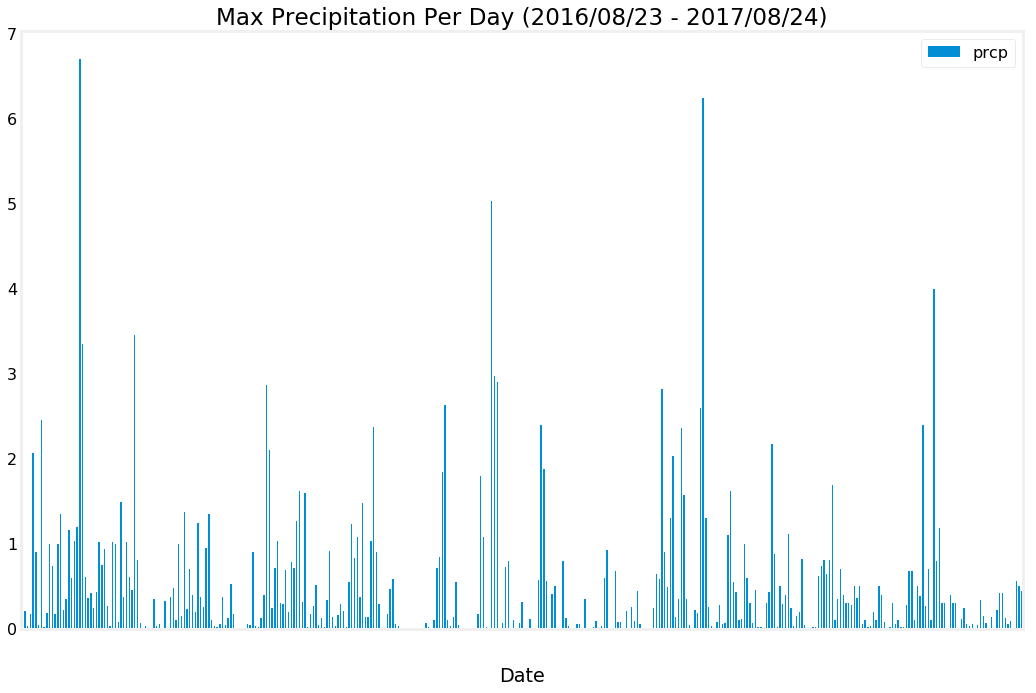

In [13]:
# Plot the data
highs_per_day_df["prcp"].plot(kind="bar", figsize=(16,11), use_index=False, grid=False, legend=True)
plt.title("Max Precipitation Per Day (2016/08/23 - 2017/08/24)")
plt.xlabel("Date")
plt.show()

In [14]:
# Calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [15]:
# Shows how many stations are available in this dataset
station_count = session.query(func.count(Station.station)).all()
station_count

[(9)]

# What are the most active stations?

In [16]:
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                            .all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?

In [17]:
top_station_stats = session.query(func.min(Measurement.tobs)
                                  , func.max(Measurement.tobs)
                                  , func.avg(Measurement.tobs))\
                                    .filter(Measurement.station == station_activity[0][0])\
                                        .all()

top_station_stats

[(54.0, 85.0, 71.66378066378067)]

# Choose the station with the highest number of temperature observations.

<Figure size 432x288 with 0 Axes>

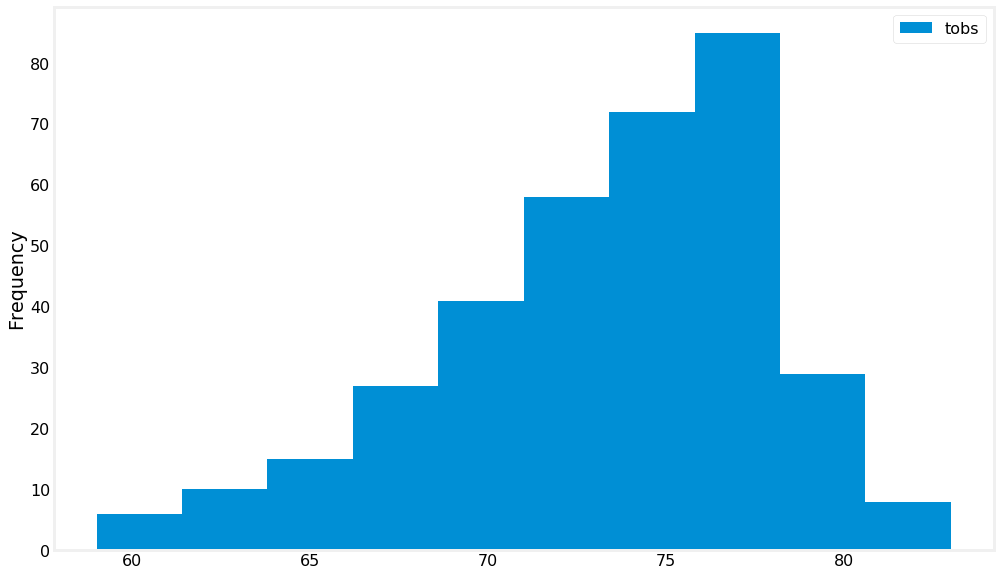

In [18]:
# The last 12 months of temperature observation data for this station and plot the results as a histogram
top_year = session.query(Measurement.station
                         , Measurement.date
                         , Measurement.tobs
                         , Measurement.prcp)\
                            .order_by(Measurement.date.asc())\
                                .filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago)\
                                    .filter(Measurement.station == station_activity[0][0])\
                                        .all()

top_year_df = pd.DataFrame(top_year)#.set_index("date")
top_tobs_df = top_year_df[["tobs"]]


plt.figure()
plt.rcParams['xtick.color'] = "black"
top_tobs_df.plot(kind="hist", figsize=(15,10), grid=False)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs)
                         , func.avg(Measurement.tobs)
                         , func.max(Measurement.tobs))\
                            .filter(Measurement.date >= start_date)\
                                .filter(Measurement.date <= end_date)\
                                    .all()

# Function usage example
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [20]:
# Calculate the tmin, tavg, and tmax for trip using the most recent year's data for those same dates.
print(calc_temps('2016-04-16', '2016-04-20')[0][0],\
      calc_temps('2016-04-16', '2016-04-20')[0][1],\
      calc_temps('2016-04-16', '2016-04-20')[0][2])

66.0 72.3225806451613 80.0


Text(0.5, 1.0, 'Trip Avg Temp')

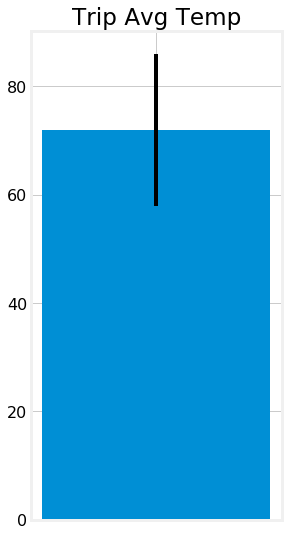

In [21]:
# Plot the results from your previous query as a bar chart. 
plt.figure(figsize=(4,9))
plt.bar(yerr=14, height=72, x="")
plt.title("Trip Avg Temp")

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates. Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [22]:
def calc_prcp(start_date, end_date):

    station_prcp = session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())\
                           .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
                                .all()
    
    for i in station_prcp:
        station = i[0]
        value = session.query(Station.station
                              , Station.name
                              , Station.latitude
                              , Station.longitude
                              , Station.elevation
                              , func.sum(Measurement.prcp))\
                                .filter(Measurement.date >= start_date)\
                                    .filter(Measurement.date <= end_date)\
                                         .filter(Measurement.station == station)\
                                             .filter(Station.station == station)\
                                                .all()
        print(value)
        
     

calc_prcp('2016-04-16', '2016-04-20')

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.1000000000000005)]
[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.45)]
[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6300000000000001)]
[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.55)]
[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.49)]
[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.32)]
[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]
